In [1]:
import pandas as pd #To import data

import folium #For map
from folium.plugins import HeatMap, HeatMapWithTime

import numpy as np

#for plots:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # Creating color bar
import seaborn as sns #Historgram

### Import data

In [2]:
# Specify the full path to the CSV file
file_path = r"C:\Users\Bruger\Documents\s194384.github.io\My final project codes\Benches.csv"

# Read data from the specified file
df = pd.read_csv(file_path)

# counts rows and columns
print(f"Total number of rows: {df.shape[0]}")
print(f"Total number of columns: {df.shape[1]}")

# Preview the first 5 lines of the loaded data
df.head()

Total number of rows: 212122
Total number of columns: 13


,time,Sensor Location,dev_id,Sensor Name,azimuthDeg,Lat Long,batV,inTrip,inclinationDeg,manDown,temp,type,xyz
0,2022-12-20T08:08:03+01:00,Seat Asset ID: 1119882,guppy-2308,Bench Sensor 1,NaN,"-37.8027388, 144.9655868",2.994,0.0,NaN,NaN,26.0,status,NaN
1,2022-12-20T08:23:11+01:00,Seat Asset ID: 1119051,guppy-2340,Bench Sensor 3,NaN,"-37.8028278, 144.9654266",2.980,0.0,NaN,NaN,26.0,status,NaN
2,2022-12-20T08:43:27+01:00,Seat Asset ID: 1119882,guppy-2332,Bench Sensor 2,NaN,"-37.8027388, 144.9655868",2.994,0.0,NaN,NaN,24.0,status,NaN
3,2022-12-21T00:21:40+01:00,Seat Asset ID: 1119051,guppy-2340,Bench Sensor 3,NaN,"-37.8028278, 144.9654266",2.980,1.0,NaN,NaN,29.0,status,NaN
4,2022-12-21T00:24:51+01:00,Seat Asset ID: 1119051,guppy-2340,Bench Sensor 3,NaN,"-37.8028278, 144.9654266",2.980,0.0,NaN,NaN,29.0,status,NaN


### Seperate time column into two columns -and the same with the Lat Long column

In [4]:
df['time'] = pd.to_datetime(df['time'], utc=True)
df['time'] = df['time'].dt.tz_convert('Australia/Melbourne')

df['date'] = df['time'].dt.date
#df['date'] = pd.to_datetime(df['date']) #set date to datetime-format
#print(df['date'].dtype) #Check to see if done correctly

df['clock'] = df['time'].dt.time

df[['Latitude', 'Longitude']] = df['Lat Long'].str.split(',', expand=True).astype(float) #splits to float


print(f"Total number of rows: {df.shape[0]}")
print(f"Total number of columns: {df.shape[1]}")

df.head()

Total number of rows: 212122
Total number of columns: 17


,time,Sensor Location,dev_id,Sensor Name,azimuthDeg,Lat Long,batV,inTrip,inclinationDeg,manDown,temp,type,xyz,date,clock,Latitude,Longitude
0,2022-12-20 18:08:03+11:00,Seat Asset ID: 1119882,guppy-2308,Bench Sensor 1,NaN,"-37.8027388, 144.9655868",2.994,0.0,NaN,NaN,26.0,status,NaN,2022-12-20,18:08:03,-37.802739,144.965587
1,2022-12-20 18:23:11+11:00,Seat Asset ID: 1119051,guppy-2340,Bench Sensor 3,NaN,"-37.8028278, 144.9654266",2.980,0.0,NaN,NaN,26.0,status,NaN,2022-12-20,18:23:11,-37.802828,144.965427
2,2022-12-20 18:43:27+11:00,Seat Asset ID: 1119882,guppy-2332,Bench Sensor 2,NaN,"-37.8027388, 144.9655868",2.994,0.0,NaN,NaN,24.0,status,NaN,2022-12-20,18:43:27,-37.802739,144.965587
3,2022-12-21 10:21:40+11:00,Seat Asset ID: 1119051,guppy-2340,Bench Sensor 3,NaN,"-37.8028278, 144.9654266",2.980,1.0,NaN,NaN,29.0,status,NaN,2022-12-21,10:21:40,-37.802828,144.965427
4,2022-12-21 10:24:51+11:00,Seat Asset ID: 1119051,guppy-2340,Bench Sensor 3,NaN,"-37.8028278, 144.9654266",2.980,0.0,NaN,NaN,29.0,status,NaN,2022-12-21,10:24:51,-37.802828,144.965427


In [5]:
# Konverter 'time' til datetime hvis ikke allerede gjort
#df['time'] = pd.to_datetime(df['time'])

# Find første og sidste dato
start_dato = df['date'].min()
slut_dato = df['date'].max()
print("Datasættet strækker sig fra", start_dato, "til", slut_dato)

# Tæl antal unikke datoer med data
#unikke_dage_med_data = df['date'].dt.date.nunique()

# Sammenlign med antal mulige dage i perioden
antal_mulige_dage = (slut_dato - start_dato).days + 1
#print("Antal dage med data:", unikke_dage_med_data)
print("Antal mulige dage:", antal_mulige_dage)

# Er der data for hver dag?
#print("Data for hver dag:", unikke_dage_med_data == antal_mulige_dage)


Datasættet strækker sig fra 2020-06-04 til 2025-07-18
Antal mulige dage: 1871


### Maps

In [6]:
unique_coordinates = df['Lat Long'].dropna().unique()
num_unique_coordinates = len(unique_coordinates)
unique_coordinates, num_unique_coordinates

(array(['-37.8027388, 144.9655868', '-37.8028278, 144.9654266'],
       dtype=object),
 2)

In [7]:
# Antal unikke sensornavne
antal_unikke_sensorer = df['Sensor Name'].nunique()
print("Antal unikke sensor navne:", antal_unikke_sensorer)


Antal unikke sensor navne: 4


In [8]:
# Startkort – centreret omkring gennemsnittet af koordinaterne
map_center = [-37.815, 144.97]
m = folium.Map(location=map_center, zoom_start=14)

# Tilføj markører
for coord in unique_coordinates:
    lat, lon = map(float, coord.split(','))
    folium.Marker(location=[lat, lon], popup=coord).add_to(m)

# Vis kortet (i Jupyter Notebook)
m

### Seperate the different sensors

In [9]:
df_sensor_1 = df[df["Sensor Name"] == "Bench Sensor 1"]
df_sensor_2 = df[df["Sensor Name"] == "Bench Sensor 2"]
df_sensor_3 = df[df["Sensor Name"] == "Bench Sensor 3"]
df_sensor_4 = df[df["Sensor Name"] == "Bench Sensor 4"]

df_sensor_1.head()

,time,Sensor Location,dev_id,Sensor Name,azimuthDeg,Lat Long,batV,inTrip,inclinationDeg,manDown,temp,type,xyz,date,clock,Latitude,Longitude
0,2022-12-20 18:08:03+11:00,Seat Asset ID: 1119882,guppy-2308,Bench Sensor 1,NaN,"-37.8027388, 144.9655868",2.994,0.0,NaN,NaN,26.0,status,NaN,2022-12-20,18:08:03,-37.802739,144.965587
5,2022-12-21 12:52:48+11:00,Seat Asset ID: 1119882,guppy-2308,Bench Sensor 1,NaN,"-37.8027388, 144.9655868",2.994,0.0,NaN,NaN,25.0,status,NaN,2022-12-21,12:52:48,-37.802739,144.965587
6,2025-01-09 08:32:29+11:00,Seat Asset ID: 1119882,guppy-2308,Bench Sensor 1,NaN,"-37.8027388, 144.9655868",2.742,1.0,NaN,NaN,22.0,status,NaN,2025-01-09,08:32:29,-37.802739,144.965587
8,2022-12-16 18:57:20+11:00,Seat Asset ID: 1119882,guppy-2308,Bench Sensor 1,NaN,"-37.8027388, 144.9655868",2.994,0.0,NaN,NaN,17.0,status,NaN,2022-12-16,18:57:20,-37.802739,144.965587
23,2022-12-19 18:41:22+11:00,Seat Asset ID: 1119882,guppy-2308,Bench Sensor 1,NaN,"-37.8027388, 144.9655868",2.994,0.0,NaN,NaN,24.0,status,NaN,2022-12-19,18:41:22,-37.802739,144.965587


In [10]:
print(f"Total number of rows: {df_sensor_1.shape[0]}")
print(f"Total number of columns: {df_sensor_1.shape[1]}")

Total number of rows: 50310
Total number of columns: 17


In [11]:
df_s1_sorted_date = df_sensor_1.sort_values(by="time")
df_s2_sorted_date = df_sensor_2.sort_values(by="time")
df_s3_sorted_date = df_sensor_3.sort_values(by="time")
df_s4_sorted_date = df_sensor_4.sort_values(by="time")

df_s1_sorted_date.head()

,time,Sensor Location,dev_id,Sensor Name,azimuthDeg,Lat Long,batV,inTrip,inclinationDeg,manDown,temp,type,xyz,date,clock,Latitude,Longitude
132351,2020-06-05 09:19:06+10:00,Seat Asset ID: 1119882,guppy-2308,Bench Sensor 1,NaN,"-37.8027388, 144.9655868",3.106,1.0,NaN,NaN,6.0,status,NaN,2020-06-05,09:19:06,-37.802739,144.965587
130815,2020-06-05 09:22:15+10:00,Seat Asset ID: 1119882,guppy-2308,Bench Sensor 1,NaN,"-37.8027388, 144.9655868",3.106,0.0,NaN,NaN,6.0,status,NaN,2020-06-05,09:22:15,-37.802739,144.965587
27681,2020-06-05 10:11:11+10:00,Seat Asset ID: 1119882,guppy-2308,Bench Sensor 1,NaN,"-37.8027388, 144.9655868",3.106,1.0,NaN,NaN,8.0,status,NaN,2020-06-05,10:11:11,-37.802739,144.965587
70939,2020-06-05 10:14:20+10:00,Seat Asset ID: 1119882,guppy-2308,Bench Sensor 1,NaN,"-37.8027388, 144.9655868",3.106,0.0,NaN,NaN,8.0,status,NaN,2020-06-05,10:14:20,-37.802739,144.965587
24247,2020-06-05 12:46:34+10:00,Seat Asset ID: 1119882,guppy-2308,Bench Sensor 1,NaN,"-37.8027388, 144.9655868",3.106,1.0,NaN,NaN,14.0,status,NaN,2020-06-05,12:46:34,-37.802739,144.965587


In [12]:
# Tom liste til at gemme dwell-perioder
dwell_times = []

# Variabler til at holde styr på inTrip-perioder
in_trip_active = False
start_time = None
temp_values = []

# Gennemløb alle rækker i det sorterede DataFrame
for idx, row in df_s1_sorted_date.iterrows():
    current_in_trip = row['inTrip']
    current_time = row['time']
    current_temp = row['temp']

    if not in_trip_active and current_in_trip == 1.0:
        # Start af en inTrip-periode
        in_trip_active = True
        start_time = current_time
        temp_values = [current_temp]

    elif in_trip_active:
        # Akkumulér temperaturer under inTrip-perioden
        temp_values.append(current_temp)

        if current_in_trip == 0.0:
            # Slut af inTrip-periode
            dwell = (current_time - start_time).total_seconds() / 60  # i minutter
            avg_temp = np.nanmean(temp_values)

            # Gem resultaterne
            dwell_times.append({
                "dwell": dwell,
                "temp": avg_temp,
                "date": start_time.date(),
                "time": start_time.time()
            })

            # Nulstil til næste periode
            in_trip_active = False
            start_time = None
            temp_values = []

# Opret DataFrame med resultaterne
df_s1 = pd.DataFrame(dwell_times)

df_s1.head()


,dwell,temp,date,time
0,3.150000,6.0,2020-06-05,09:19:06
1,3.150000,8.0,2020-06-05,10:11:11
2,7.216667,14.0,2020-06-05,12:46:34
3,3.116667,14.5,2020-06-05,13:04:14
4,2.966667,15.0,2020-06-05,13:24:58


In [13]:
print(f"Total number of rows: {df_s1.shape[0]}")
print(f"Total number of columns: {df_s1.shape[1]}")

Total number of rows: 23853
Total number of columns: 4


In [14]:
# Tom liste til at gemme dwell-perioder
dwell_times = []

# Variabler til at holde styr på inTrip-perioder
in_trip_active = False
start_time = None
temp_values = []

# Gennemløb alle rækker i det sorterede DataFrame
for idx, row in df_s2_sorted_date.iterrows():
    current_in_trip = row['inTrip']
    current_time = row['time']
    current_temp = row['temp']

    if not in_trip_active and current_in_trip == 1.0:
        # Start af en inTrip-periode
        in_trip_active = True
        start_time = current_time
        temp_values = [current_temp]

    elif in_trip_active:
        # Akkumulér temperaturer under inTrip-perioden
        temp_values.append(current_temp)

        if current_in_trip == 0.0:
            # Slut af inTrip-periode
            dwell = (current_time - start_time).total_seconds() / 60  # i minutter
            avg_temp = np.nanmean(temp_values)

            # Gem resultaterne
            dwell_times.append({
                "dwell": dwell,
                "temp": avg_temp,
                "date": start_time.date(),
                "time": start_time.time()
            })

            # Nulstil til næste periode
            in_trip_active = False
            start_time = None
            temp_values = []

# Opret DataFrame med resultaterne
df_s2 = pd.DataFrame(dwell_times)

df_s2.head()

,dwell,temp,date,time
0,2.200000,6.0,2020-06-05,09:15:08
1,4.133333,6.0,2020-06-05,09:18:24
2,3.166667,8.0,2020-06-05,10:11:14
3,2.950000,13.0,2020-06-05,12:43:55
4,3.000000,13.0,2020-06-05,12:50:07


In [15]:
# Tom liste til at gemme dwell-perioder
dwell_times = []

# Variabler til at holde styr på inTrip-perioder
in_trip_active = False
start_time = None
temp_values = []

# Gennemløb alle rækker i det sorterede DataFrame
for idx, row in df_s3_sorted_date.iterrows():
    current_in_trip = row['inTrip']
    current_time = row['time']
    current_temp = row['temp']

    if not in_trip_active and current_in_trip == 1.0:
        # Start af en inTrip-periode
        in_trip_active = True
        start_time = current_time
        temp_values = [current_temp]

    elif in_trip_active:
        # Akkumulér temperaturer under inTrip-perioden
        temp_values.append(current_temp)

        if current_in_trip == 0.0:
            # Slut af inTrip-periode
            dwell = (current_time - start_time).total_seconds() / 60  # i minutter
            avg_temp = np.nanmean(temp_values)

            # Gem resultaterne
            dwell_times.append({
                "dwell": dwell,
                "temp": avg_temp,
                "date": start_time.date(),
                "time": start_time.time()
            })

            # Nulstil til næste periode
            in_trip_active = False
            start_time = None
            temp_values = []

# Opret DataFrame med resultaterne
df_s3 = pd.DataFrame(dwell_times)

df_s3.head()

,dwell,temp,date,time
0,2.250000,21.0,2020-06-04,13:09:08
1,3.016667,21.5,2020-06-04,13:28:29
2,7.150000,20.0,2020-06-04,13:48:30
3,10.233333,19.0,2020-06-04,13:56:19
4,2.966667,17.0,2020-06-04,14:19:03


In [16]:
# Tom liste til at gemme dwell-perioder
dwell_times = []

# Variabler til at holde styr på inTrip-perioder
in_trip_active = False
start_time = None
temp_values = []

# Gennemløb alle rækker i det sorterede DataFrame
for idx, row in df_s4_sorted_date.iterrows():
    current_in_trip = row['inTrip']
    current_time = row['time']
    current_temp = row['temp']

    if not in_trip_active and current_in_trip == 1.0:
        # Start af en inTrip-periode
        in_trip_active = True
        start_time = current_time
        temp_values = [current_temp]

    elif in_trip_active:
        # Akkumulér temperaturer under inTrip-perioden
        temp_values.append(current_temp)

        if current_in_trip == 0.0:
            # Slut af inTrip-periode
            dwell = (current_time - start_time).total_seconds() / 60  # i minutter
            avg_temp = np.nanmean(temp_values)

            # Gem resultaterne
            dwell_times.append({
                "dwell": dwell,
                "temp": avg_temp,
                "date": start_time.date(),
                "time": start_time.time()
            })

            # Nulstil til næste periode
            in_trip_active = False
            start_time = None
            temp_values = []

# Opret DataFrame med resultaterne
df_s4 = pd.DataFrame(dwell_times)

df_s4.head()

,dwell,temp,date,time
0,2.383333,22.0,2020-06-04,13:09:01
1,3.033333,22.0,2020-06-04,13:25:28
2,2.550000,22.0,2020-06-04,13:29:06
3,3.100000,20.0,2020-06-04,13:50:16
4,4.100000,17.5,2020-06-04,14:01:58


### Time plots

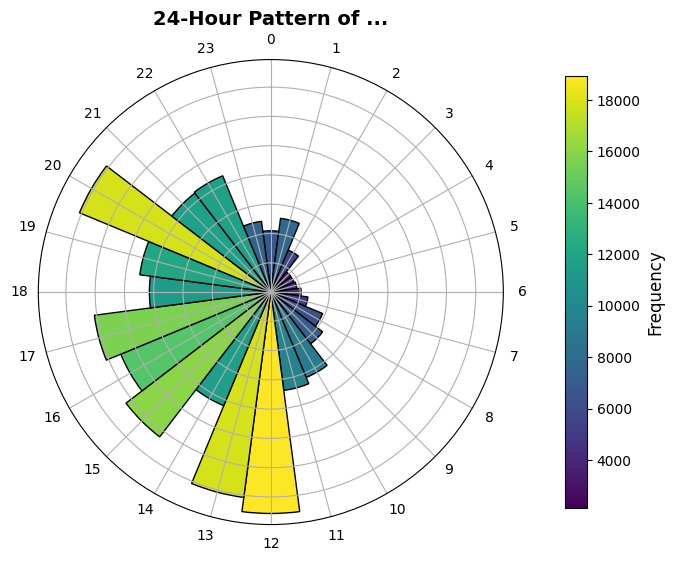

In [17]:
#df_s1['hour'] = pd.to_datetime(df_s1['time']).dt.hour
df_s1["hour"] = df_s1["time"].apply(lambda t: t.hour)
#df_s1["minute"] = df_s1["time"].apply(lambda t: t.minute)

hours = df_s1.groupby('hour')['dwell'].sum()
#hours = df_s1.groupby('hour')['dwell'].mean()

#hours = df_park['time'].value_counts().sort_index()
angles = np.linspace(0, 2 * np.pi, len(hours), endpoint=False)
widths = np.pi / 12 
colors = plt.cm.viridis(hours.values / hours.values.max())

# Plot settings
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
bars = ax.bar(angles, hours.values, width=widths, color=colors, edgecolor='black')

# Make the chart look like a clock
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap='viridis',norm=mcolors.Normalize(vmin=hours.values.min(), vmax=hours.values.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.7, pad=0.1)
cbar.set_label('Frequency',fontsize=12)

# Set labels and title
ax.set_xticks(angles)
ax.set_xticklabels(hours.index, fontsize=10)
ax.set_yticklabels([])
ax.set_title('24-Hour Pattern of ...', fontsize=14, fontweight='bold')

# Show plot
plt.show()

### Bokeh

In [18]:
##Cirkel
## OBS simuleret data!!! ##
'''
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category10

# ========= Simuleret data (Erstat med dine egne df_s1...df_s4) =========
# Her simulerer vi dataframe med 'time' og 'dwell' for hver sensor
rng = pd.date_range("2025-01-01", periods=1000, freq="H")
make_df = lambda name: pd.DataFrame({
    "sensor": name,
    "time": rng,
    "dwell": np.random.poisson(lam=10 + 5*np.random.rand(), size=len(rng))
})

df_s1 = make_df("s1")
df_s2 = make_df("s2")
df_s3 = make_df("s3")
df_s4 = make_df("s4")

# ========= Beregn dwell per time for hver sensor =========
def prepare_sensor_data(df, label):
    df["hour"] = df["time"].dt.hour
    grouped = df.groupby("hour")["dwell"].sum()
    grouped = grouped.sort_index()
    return grouped.rename(label)

data = pd.concat([
    prepare_sensor_data(df_s1, "s1"),
    prepare_sensor_data(df_s2, "s2"),
    prepare_sensor_data(df_s3, "s3"),
    prepare_sensor_data(df_s4, "s4")
], axis=1).fillna(0)

# ========= Konverter til (x, y) koordinater for polar visning =========
angles = np.linspace(0, 2 * np.pi, 24, endpoint=False)
hour_labels = list(range(24))

source_data = {"angle": angles, "hour": hour_labels}
for sensor in data.columns:
    r = data[sensor].values
    source_data[f"{sensor}_x"] = np.cos(angles) * r
    source_data[f"{sensor}_y"] = np.sin(angles) * r

source = ColumnDataSource(data=source_data)

# ========= Opret figur =========
p = figure(
    title="24-Hour Pattern of Dwell Time per Sensor",
    x_axis_type=None, y_axis_type=None,
    width=700, height=700,
    toolbar_location=None,
    match_aspect=True
)

# ========= Tilføj cirkler (urets markeringer) =========
r_max = data.max().max()
for r in [r_max * 0.25, r_max * 0.5, r_max * 0.75, r_max]:
    p.circle(x=0, y=0, radius=r, fill_color=None, line_color="lightgrey")

# ========= Tilføj time-etiketter =========
label_angles = angles
for i, angle in enumerate(label_angles):
    x = np.cos(angle) * (r_max * 1.1)
    y = np.sin(angle) * (r_max * 1.1)
    p.text(x=[x], y=[y], text=[str(i)], text_align="center", text_baseline="middle", text_font_size="10pt")

# ========= Tegn linjer og punkter for hver sensor =========
colors = Category10[4]
for i, sensor in enumerate(data.columns):
    p.line(x=f"{sensor}_x", y=f"{sensor}_y", source=source,
           color=colors[i], line_width=2, legend_label=sensor,
           muted_alpha=0.1, muted=True)
    p.circle(x=f"{sensor}_x", y=f"{sensor}_y", source=source,
             color=colors[i], size=6, legend_label=sensor,
             muted_alpha=0.1, muted=True)

# ========= Interaktiv legend =========
p.legend.title = "Sensors"
p.legend.click_policy = "mute"
p.legend.location = "top_left"

# ========= Vis plot =========
show(p)
'''

'\nimport pandas as pd\nimport numpy as np\nfrom bokeh.plotting import figure, show\nfrom bokeh.models import ColumnDataSource\nfrom bokeh.palettes import Category10\n\n# ========= Simuleret data (Erstat med dine egne df_s1...df_s4) =========\n# Her simulerer vi dataframe med \'time\' og \'dwell\' for hver sensor\nrng = pd.date_range("2025-01-01", periods=1000, freq="H")\nmake_df = lambda name: pd.DataFrame({\n    "sensor": name,\n    "time": rng,\n    "dwell": np.random.poisson(lam=10 + 5*np.random.rand(), size=len(rng))\n})\n\ndf_s1 = make_df("s1")\ndf_s2 = make_df("s2")\ndf_s3 = make_df("s3")\ndf_s4 = make_df("s4")\n\n# ========= Beregn dwell per time for hver sensor =========\ndef prepare_sensor_data(df, label):\n    df["hour"] = df["time"].dt.hour\n    grouped = df.groupby("hour")["dwell"].sum()\n    grouped = grouped.sort_index()\n    return grouped.rename(label)\n\ndata = pd.concat([\n    prepare_sensor_data(df_s1, "s1"),\n    prepare_sensor_data(df_s2, "s2"),\n    prepare_senso

In [19]:
'''
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Select, HoverTool, Legend, CustomJS
from bokeh.layouts import column
from bokeh.io import output_notebook
output_notebook()

datasets = {
    "df_s1": df_s1,
    "df_s2": df_s2,
    "df_s3": df_s3,
    "df_s4": df_s4
}

# Funktion til at udtrække 'dwell' summeret per time
def process(df):
    df["hour"] = pd.to_datetime(df["time"]).dt.hour
    hourly = df.groupby("hour")["dwell"].sum().reindex(range(24), fill_value=0)
    return hourly

# Initial dataset
initial_name = "df_s1"
initial_data = process(datasets[initial_name])
source = ColumnDataSource(data={
    'hour': list(range(24)),
    'dwell': initial_data.values
})

# Bokeh-plot
p = figure(title="Hourly Dwell Pattern", x_axis_label="Hour of Day", y_axis_label="Total Dwell",
           x_range=(0, 23), tools="pan,wheel_zoom,box_zoom,reset,save")

line = p.line(x='hour', y='dwell', source=source, line_width=3, color="forestgreen", legend_label=initial_name)
circle = p.circle(x='hour', y='dwell', source=source, size=6, color="forestgreen")

hover = HoverTool(tooltips=[("Hour", "@hour"), ("Dwell", "@dwell")])
p.add_tools(hover)
p.legend.location = "top_left"

# Dropdown menu
select = Select(title="Vælg dataset:", value=initial_name, options=list(datasets.keys()))

# Callback til at opdatere plottet
def update(attr, old, new):
    new_data = process(datasets[new])
    source.data = {
        'hour': list(range(24)),
        'dwell': new_data.values
    }
    line.legend_label = new

select.on_change("value", update)

layout = column(select, p)
show(layout)
'''

'\nimport pandas as pd\nimport numpy as np\nfrom bokeh.plotting import figure, show\nfrom bokeh.models import ColumnDataSource, Select, HoverTool, Legend, CustomJS\nfrom bokeh.layouts import column\nfrom bokeh.io import output_notebook\noutput_notebook()\n\ndatasets = {\n    "df_s1": df_s1,\n    "df_s2": df_s2,\n    "df_s3": df_s3,\n    "df_s4": df_s4\n}\n\n# Funktion til at udtrække \'dwell\' summeret per time\ndef process(df):\n    df["hour"] = pd.to_datetime(df["time"]).dt.hour\n    hourly = df.groupby("hour")["dwell"].sum().reindex(range(24), fill_value=0)\n    return hourly\n\n# Initial dataset\ninitial_name = "df_s1"\ninitial_data = process(datasets[initial_name])\nsource = ColumnDataSource(data={\n    \'hour\': list(range(24)),\n    \'dwell\': initial_data.values\n})\n\n# Bokeh-plot\np = figure(title="Hourly Dwell Pattern", x_axis_label="Hour of Day", y_axis_label="Total Dwell",\n           x_range=(0, 23), tools="pan,wheel_zoom,box_zoom,reset,save")\n\nline = p.line(x=\'hour\',

In [20]:
'''
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Select, HoverTool
from bokeh.layouts import column
from bokeh.palettes import Category10
from bokeh.io import output_notebook
output_notebook()

datasets = {
    "df_s1": df_s1,
    "df_s2": df_s2,
    "df_s3": df_s3,
    "df_s4": df_s4
}

def process(df):
    df["hour"] = pd.to_datetime(df["time"]).dt.hour
    hourly = df.groupby("hour")["dwell"].sum().reindex(range(24), fill_value=0)
    return hourly

# Behandling af alle datasæt
processed = {name: process(df) for name, df in datasets.items()}
hours = list(range(24))

# Opret datasources for hver
sources = {}
for name, series in processed.items():
    sources[name] = ColumnDataSource(data={'hour': hours, 'dwell': series.values})

# Initialt valgt
initial = "df_s1"
colors = Category10[10]
p = figure(title="Hourly Dwell per Dataset", x_axis_label="Hour of Day", y_axis_label="Total Dwell",
           x_range=(0, 23), tools="pan,wheel_zoom,box_zoom,reset,save")

renderers = {}

# Tegn alle linjer og cirkler
for i, (name, source) in enumerate(sources.items()):
    line_color = colors[i % len(colors)]
    alpha_val = 1.0 if name == initial else 0.2
    width = 3 if name == initial else 2

    line = p.line('hour', 'dwell', source=source, line_width=width, alpha=alpha_val, color=line_color, legend_label=name, name=name)
    circle = p.circle('hour', 'dwell', source=source, size=5, alpha=alpha_val, color=line_color, name=name)
    renderers[name] = (line, circle)

# Hover tool på det aktive datasæt
hover = HoverTool(tooltips=[("Hour", "@hour"), ("Dwell", "@dwell")], renderers=[renderers[initial][0]])
p.add_tools(hover)
p.legend.location = "top_left"

# Dropdown til valg af fokus
select = Select(title="Fremhæv datasæt:", value=initial, options=list(datasets.keys()))

# Callback
def update(attr, old, new):
    for name, (line, circle) in renderers.items():
        if name == new:
            line.glyph.line_alpha = 1.0
            line.glyph.line_width = 3
            circle.glyph.fill_alpha = 1.0
            circle.glyph.size = 6
        else:
            line.glyph.line_alpha = 0.2
            line.glyph.line_width = 2
            circle.glyph.fill_alpha = 0.2
            circle.glyph.size = 5
    hover.renderers = [renderers[new][0]]

select.on_change('value', update)

# Layout
layout = column(select, p)
show(layout)

from bokeh.plotting import output_file, save

output_file("plot.html")  # navnet på filen
save(layout)              # 'layout' er det Bokeh-layout, du har lavet
'''

'\nimport pandas as pd\nimport numpy as np\nfrom bokeh.plotting import figure, show\nfrom bokeh.models import ColumnDataSource, Select, HoverTool\nfrom bokeh.layouts import column\nfrom bokeh.palettes import Category10\nfrom bokeh.io import output_notebook\noutput_notebook()\n\ndatasets = {\n    "df_s1": df_s1,\n    "df_s2": df_s2,\n    "df_s3": df_s3,\n    "df_s4": df_s4\n}\n\ndef process(df):\n    df["hour"] = pd.to_datetime(df["time"]).dt.hour\n    hourly = df.groupby("hour")["dwell"].sum().reindex(range(24), fill_value=0)\n    return hourly\n\n# Behandling af alle datasæt\nprocessed = {name: process(df) for name, df in datasets.items()}\nhours = list(range(24))\n\n# Opret datasources for hver\nsources = {}\nfor name, series in processed.items():\n    sources[name] = ColumnDataSource(data={\'hour\': hours, \'dwell\': series.values})\n\n# Initialt valgt\ninitial = "df_s1"\ncolors = Category10[10]\np = figure(title="Hourly Dwell per Dataset", x_axis_label="Hour of Day", y_axis_label="

In [21]:
'''
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, ColorBar, LinearColorMapper, Select, CustomJS
from bokeh.layouts import column
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256

datasets = {
    "df_s1": df_s1,
    "df_s2": df_s2,
    "df_s3": df_s3,
    "df_s4": df_s4
}

def get_hourly_data(df):
    df["hour"] = pd.to_datetime(df["time"]).dt.hour
    hourly = df.groupby("hour")["dwell"].sum().reindex(range(24), fill_value=0)
    return hourly

# Initial data
initial_name = "df_s1"
hourly = get_hourly_data(datasets[initial_name])

# Polar coordinates
angles = np.linspace(0, 2 * np.pi, 24, endpoint=False)
radii = hourly.values
max_r = radii.max()

source = ColumnDataSource(data=dict(
    angle=angles,
    radius=radii,
    hour=[str(h) for h in range(24)],
    color=linear_cmap('radius', Viridis256, low=radii.min(), high=radii.max()).transform(radii)
))

p = figure(width=600, height=600, title="24-Hour Pattern of ...", x_axis_type=None, y_axis_type=None,
           tools="", toolbar_location=None, match_aspect=True)

p.annular_wedge(
    x=0, y=0,
    inner_radius=0,
    outer_radius='radius',
    start_angle='angle',
    end_angle='angle',
    direction="clock",
    color='color',
    source=source,
    line_color="black"
)

# Clock-like setup
p.grid.visible = False
p.outline_line_color = None
for i in range(24):
    angle = angles[i]
    x = 1.2 * max_r * np.cos(angle)
    y = 1.2 * max_r * np.sin(angle)
    p.text([x], [y], text=[str(i)], text_align='center', text_baseline='middle')

# Dropdown menu
select = Select(title="Vælg dataset:", value=initial_name, options=list(datasets.keys()))

callback = CustomJS(args=dict(source=source, datasets=datasets, select=select), code="""
    const data = source.data;
    const selected = select.value;
    const raw = datasets[selected];
    
    const dwell = {};
    for (let i = 0; i < 24; i++) dwell[i] = 0;

    for (let i = 0; i < raw.time.length; i++) {
        const hour = new Date(raw.time[i]).getHours();
        dwell[hour] += raw.dwell[i];
    }

    const radius = [];
    const color = [];
    const min_val = Math.min(...Object.values(dwell));
    const max_val = Math.max(...Object.values(dwell));

    function getColor(val) {
        const scale = (val - min_val) / (max_val - min_val);
        const idx = Math.floor(scale * 255);
        return Bokeh.require("core/util/color").color2rgba(Viridis256[idx]);
    }

    for (let i = 0; i < 24; i++) {
        radius[i] = dwell[i];
        color[i] = getColor(dwell[i]);
    }

    data['radius'] = radius;
    data['color'] = color;
    source.change.emit();
""")

select.js_on_change('value', callback)

layout = column(select, p)
show(layout)
'''

'\nimport pandas as pd\nimport numpy as np\nfrom bokeh.plotting import figure, show\nfrom bokeh.models import ColumnDataSource, ColorBar, LinearColorMapper, Select, CustomJS\nfrom bokeh.layouts import column\nfrom bokeh.transform import linear_cmap\nfrom bokeh.palettes import Viridis256\n\ndatasets = {\n    "df_s1": df_s1,\n    "df_s2": df_s2,\n    "df_s3": df_s3,\n    "df_s4": df_s4\n}\n\ndef get_hourly_data(df):\n    df["hour"] = pd.to_datetime(df["time"]).dt.hour\n    hourly = df.groupby("hour")["dwell"].sum().reindex(range(24), fill_value=0)\n    return hourly\n\n# Initial data\ninitial_name = "df_s1"\nhourly = get_hourly_data(datasets[initial_name])\n\n# Polar coordinates\nangles = np.linspace(0, 2 * np.pi, 24, endpoint=False)\nradii = hourly.values\nmax_r = radii.max()\n\nsource = ColumnDataSource(data=dict(\n    angle=angles,\n    radius=radii,\n    hour=[str(h) for h in range(24)],\n    color=linear_cmap(\'radius\', Viridis256, low=radii.min(), high=radii.max()).transform(radii

In [22]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category10

# Antagelse: dine dataframes df_s1, df_s2, df_s3, df_s4 er allerede læst ind
# og 'time' er i datetime-format (fx datetime64[ns] eller datetime.time)

# Udtræk time direkte (ingen konvertering nødvendig)
'''df_s1["hour"] = df_s1["time"].dt.hour
df_s2["hour"] = df_s2["time"].dt.hour
df_s3["hour"] = df_s3["time"].dt.hour
df_s4["hour"] = df_s4["time"].dt.hour'''

df_s1["hour"] = df_s1["time"].apply(lambda t: t.hour)
df_s2["hour"] = df_s2["time"].apply(lambda t: t.hour)
df_s3["hour"] = df_s3["time"].apply(lambda t: t.hour)
df_s4["hour"] = df_s4["time"].apply(lambda t: t.hour)

# ========= Gruppér og summer dwell per time =========
def prepare_sensor_data(df, label):
    #df["hour"] = df["time"].dt.hour #Gøres ovenover
    grouped = df.groupby("hour")["dwell"].sum()
    grouped = grouped.sort_index()
    return grouped.rename(label)

data = pd.concat([
    prepare_sensor_data(df_s1, "s1"),
    prepare_sensor_data(df_s2, "s2"),
    prepare_sensor_data(df_s3, "s3"),
    prepare_sensor_data(df_s4, "s4")
], axis=1).fillna(0)

# ========= Konverter til ColumnDataSource =========
source_data = {"hour": list(range(24))}
for sensor in data.columns:
    source_data[sensor] = data[sensor].values

source = ColumnDataSource(data=source_data)

# ========= Opret line chart figur =========
p = figure(
    title="Dwell Time per Hour – All Sensors",
    x_axis_label="Hour of Day",
    y_axis_label="Sum of Dwell",
    x_range=(0, 23),
    width=900,
    height=400,
    toolbar_location=None
)

colors = Category10[4]
for i, sensor in enumerate(data.columns):
    p.line(x='hour', y=sensor, source=source,
           line_width=2, color=colors[i],
           legend_label=sensor,
           muted_alpha=0.1, muted=True)
    p.circle(x='hour', y=sensor, source=source,
             size=5, color=colors[i],
             muted_alpha=0.1, muted=True)

# ========= Klikbar legend =========
p.legend.title = "Sensors"
p.legend.click_policy = "mute"
p.legend.location = "top_left"
p.legend.label_text_font_size = "10pt"
p.xaxis.ticker = list(range(0, 24))

# ========= Vis plot =========
show(p)


In [23]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Legend, LegendItem
from bokeh.palettes import Category10
import pandas as pd

# ========= Forbered data =========
df_s1["hour"] = df_s1["time"].apply(lambda t: t.hour)
df_s2["hour"] = df_s2["time"].apply(lambda t: t.hour)
df_s3["hour"] = df_s3["time"].apply(lambda t: t.hour)
df_s4["hour"] = df_s4["time"].apply(lambda t: t.hour)

def prepare_sensor_data(df, label):
    grouped = df.groupby("hour")["dwell"].sum()
    return grouped.sort_index().rename(label)

data = pd.concat([
    prepare_sensor_data(df_s1, "s1"),
    prepare_sensor_data(df_s2, "s2"),
    prepare_sensor_data(df_s3, "s3"),
    prepare_sensor_data(df_s4, "s4")
], axis=1).fillna(0)

# ========= Bokeh source setup =========
source_data = {"hour": list(range(24))}
for sensor in data.columns:
    source_data[sensor] = data[sensor].values
source = ColumnDataSource(data=source_data)

# ========= Opret figur =========
p = figure(
    title="Dwell Time per Hour – All Sensors",
    x_axis_label="Hour of Day",
    y_axis_label="Sum of Dwell",
    x_range=(0, 23),
    width=900,
    height=400,
    toolbar_location=None
)

colors = Category10[4]
sensor_labels = ["s1", "s2", "s3", "s4"]
sensor_groups = ["Bench 1", "Bench 1", "Bench 2", "Bench 2"]
legend_items = []

# ========= Tegn linjer og gem legend_items =========
for i, sensor in enumerate(sensor_labels):
    line = p.line(x='hour', y=sensor, source=source,
                  line_width=2, color=colors[i],
                  muted_alpha=0.1, muted=True)
    circle = p.circle(x='hour', y=sensor, source=source,
                      size=5, color=colors[i],
                      muted_alpha=0.1, muted=True)
    legend_items.append((sensor_groups[i], sensor, [line, circle]))

# ========= Lav grupperet legend =========
legend = Legend(items=[], click_policy="mute", label_text_font_size="10pt")

# Find unikke grupper og tilføj dem som overskrifter
added_groups = set()
for group, label, renderers in legend_items:
    if group not in added_groups:
        legend.items.append(LegendItem(label=group, renderers=[]))  # overskrift
        added_groups.add(group)
    legend.items.append(LegendItem(label=label, renderers=renderers))  # sensor-linje

# ========= Tilføj legend udenfor plottet =========
p.add_layout(legend, 'right')
p.xaxis.ticker = list(range(0, 24))

# ========= Vis plot =========
show(p)


In [24]:
'''
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Legend
from bokeh.palettes import Category10
import pandas as pd
import numpy as np

# Antagelse: dine dataframes df_s1, df_s2, df_s3, df_s4 er allerede læst ind
# og 'time' er i datetime-format (fx datetime64[ns] eller datetime.time)

# Udtræk time direkte (ingen konvertering nødvendig)
df_s1["hour"] = df_s1["time"].dt.hour
df_s2["hour"] = df_s2["time"].dt.hour
df_s3["hour"] = df_s3["time"].dt.hour
df_s4["hour"] = df_s4["time"].dt.hour


# ======= Beregn dwell per time =======
def prepare_sensor_data(df, label):
    df["hour"] = df["time"].dt.hour
    return df.groupby("hour")["dwell"].sum().sort_index().rename(label)

data = pd.concat([
    prepare_sensor_data(df_s1, "s1"),
    prepare_sensor_data(df_s2, "s2"),
    prepare_sensor_data(df_s3, "s3"),
    prepare_sensor_data(df_s4, "s4")
], axis=1).fillna(0)

# ======= ColumnDataSource setup =======
source_data = {"hour": list(range(24))}
for sensor in data.columns:
    source_data[sensor] = data[sensor].values
source = ColumnDataSource(data=source_data)

# ======= Figur uden legend indbygget =======
p = figure(
    title="Dwell Time per Hour – All Sensors",
    x_axis_label="Hour of Day",
    y_axis_label="Sum of Dwell",
    x_range=(0, 23),
    width=900,
    height=400,
    toolbar_location=None
)

colors = Category10[4]
legend_items = []

# ======= Tegn linjer og gem legend items =======
for i, sensor in enumerate(data.columns):
    line = p.line(x='hour', y=sensor, source=source,
                  line_width=2, color=colors[i],
                  muted_alpha=0.1, muted=True)
    circle = p.circle(x='hour', y=sensor, source=source,
                      size=5, color=colors[i],
                      muted_alpha=0.1, muted=True)
    legend_items.append((sensor, [line, circle]))

# ======= Legend udenfor figuren (til højre) =======
legend = Legend(items=legend_items, title="Sensors", click_policy="mute",
                label_text_font_size="10pt")
p.add_layout(legend, 'right')

# ======= Ekstra styling =======
p.xaxis.ticker = list(range(24))

# ======= Vis plot =======
show(p)
'''

'\nfrom bokeh.plotting import figure, show\nfrom bokeh.models import ColumnDataSource, Legend\nfrom bokeh.palettes import Category10\nimport pandas as pd\nimport numpy as np\n\n# Antagelse: dine dataframes df_s1, df_s2, df_s3, df_s4 er allerede læst ind\n# og \'time\' er i datetime-format (fx datetime64[ns] eller datetime.time)\n\n# Udtræk time direkte (ingen konvertering nødvendig)\ndf_s1["hour"] = df_s1["time"].dt.hour\ndf_s2["hour"] = df_s2["time"].dt.hour\ndf_s3["hour"] = df_s3["time"].dt.hour\ndf_s4["hour"] = df_s4["time"].dt.hour\n\n\n# ======= Beregn dwell per time =======\ndef prepare_sensor_data(df, label):\n    df["hour"] = df["time"].dt.hour\n    return df.groupby("hour")["dwell"].sum().sort_index().rename(label)\n\ndata = pd.concat([\n    prepare_sensor_data(df_s1, "s1"),\n    prepare_sensor_data(df_s2, "s2"),\n    prepare_sensor_data(df_s3, "s3"),\n    prepare_sensor_data(df_s4, "s4")\n], axis=1).fillna(0)\n\n# ======= ColumnDataSource setup =======\nsource_data = {"hour":

### Temperatur

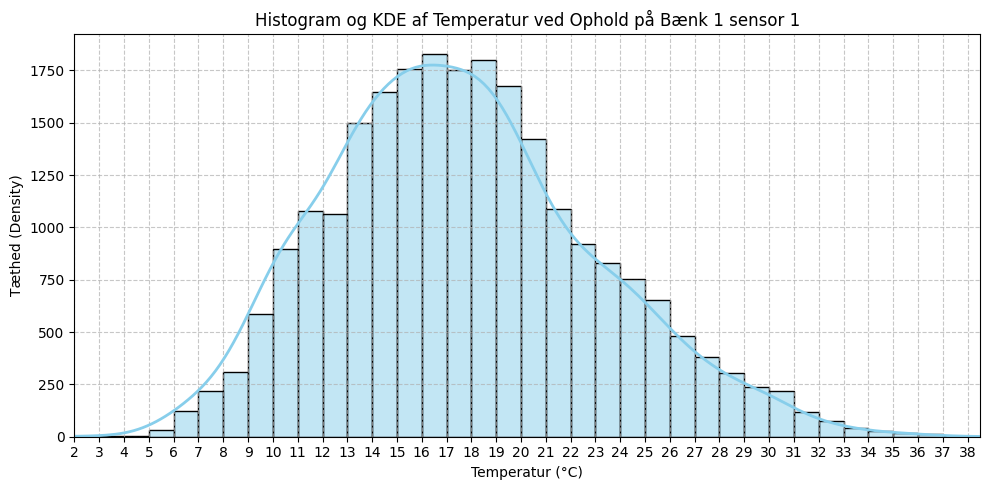

In [36]:
##Brug dette for at undersøge med dwell
# Fjern rækker med NaN i 'temp' eller 'dwell'
df_plot = df_s1.dropna(subset=["temp", "dwell"])

# Udvid x-aksen lidt for pænere plot
temp_extended = np.append(df_plot["temp"], df_plot["temp"].max() + 1)
dwell_extended = np.append(df_plot["dwell"], 0)  # Tilføj 0 for at matche længden


##Brug dette for at under søge antal observationer
# Fjern NaNs og tilføj en dummy-værdi for at udvide x-aksen en smule
#temp_extended = np.append(df_s1["temp"].dropna(), df_s1["temp"].max() + 1)

## Plot histogram og KDE
plt.figure(figsize=(10, 5))
sns.histplot(
    temp_extended,
    kde=True,
    bins=np.arange(df_s1["temp"].min(), df_s1["temp"].max() + 2, 1),  # Ét bin per grad
    color="skyblue",
    alpha=0.5,
    #stat="density",
    stat="count",
    kde_kws={'bw_adjust': 1.5, 'cut': 0},     # Glat KDE
    line_kws={'color': 'red', 'linewidth': 2}
)

plt.title("Histogram og KDE af Temperatur ved Ophold på Bænk 1 sensor 1")
plt.xlabel("Temperatur (°C)")
plt.ylabel("Tæthed (Density)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(df_s1["temp"].min(), df_s1["temp"].max() + 1)


# X-ticks svarer til hele temperaturgrader
plt.xticks(np.arange(int(df_s1["temp"].min()), int(df_s1["temp"].max()) + 2, 1))

plt.tight_layout()
plt.show()

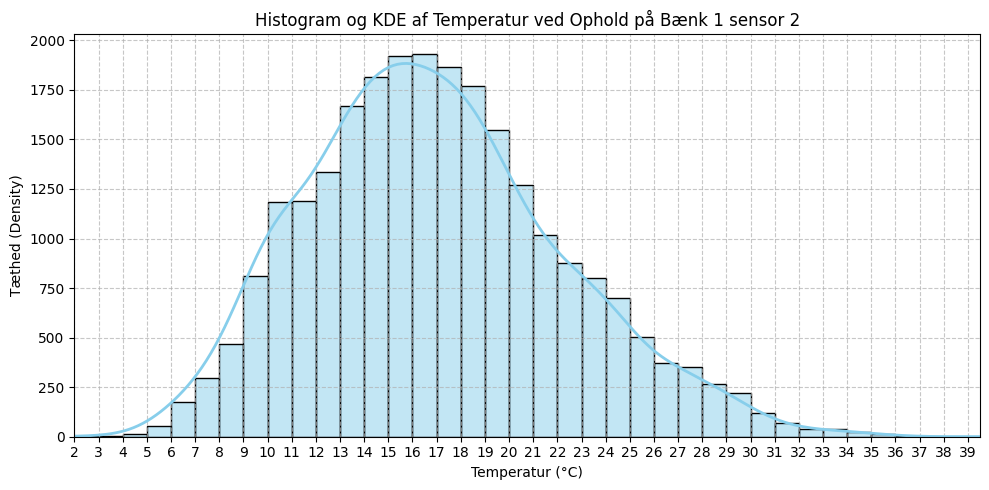

In [40]:
##Brug dette for at undersøge med dwell
# Fjern rækker med NaN i 'temp' eller 'dwell'
df_plot = df_s2.dropna(subset=["temp", "dwell"])

# Udvid x-aksen lidt for pænere plot
temp_extended = np.append(df_plot["temp"], df_plot["temp"].max() + 1)
dwell_extended = np.append(df_plot["dwell"], 0)  # Tilføj 0 for at matche længden


##Brug dette for at under søge antal observationer
# Fjern NaNs og tilføj en dummy-værdi for at udvide x-aksen en smule
#temp_extended = np.append(df_s1["temp"].dropna(), df_s1["temp"].max() + 1)

## Plot histogram og KDE
plt.figure(figsize=(10, 5))
sns.histplot(
    temp_extended,
    kde=True,
    bins=np.arange(df_s2["temp"].min(), df_s2["temp"].max() + 2, 1),  # Ét bin per grad
    color="skyblue",
    alpha=0.5,
    #stat="density",
    stat="count",
    kde_kws={'bw_adjust': 1.5, 'cut': 0},     # Glat KDE
    line_kws={'color': 'red', 'linewidth': 2}
)

plt.title("Histogram og KDE af Temperatur ved Ophold på Bænk 1 sensor 2")
plt.xlabel("Temperatur (°C)")
plt.ylabel("Tæthed (Density)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(df_s2["temp"].min(), df_s2["temp"].max() + 1)


# X-ticks svarer til hele temperaturgrader
plt.xticks(np.arange(int(df_s2["temp"].min()), int(df_s2["temp"].max()) + 2, 1))

plt.tight_layout()
plt.show()

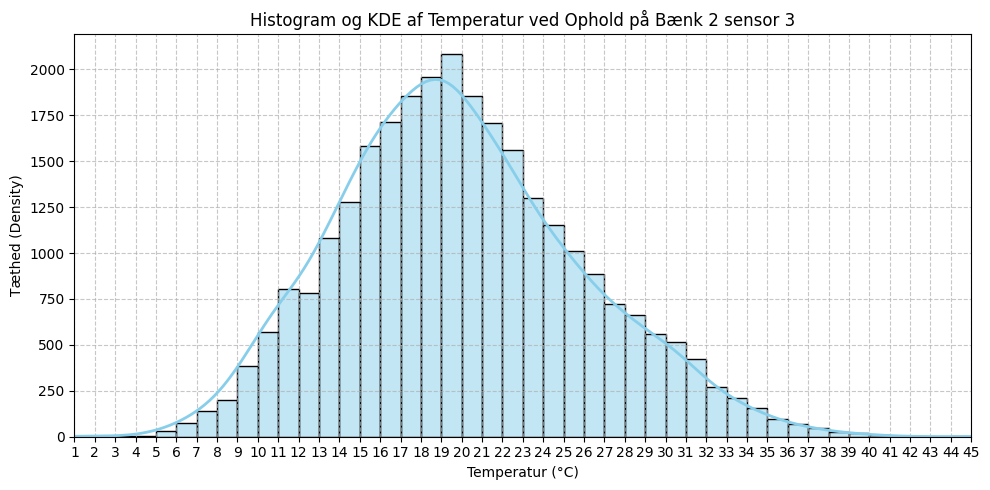

In [42]:
##Brug dette for at undersøge med dwell
# Fjern rækker med NaN i 'temp' eller 'dwell'
df_plot = df_s3.dropna(subset=["temp", "dwell"])

# Udvid x-aksen lidt for pænere plot
temp_extended = np.append(df_plot["temp"], df_plot["temp"].max() + 1)
dwell_extended = np.append(df_plot["dwell"], 0)  # Tilføj 0 for at matche længden


##Brug dette for at under søge antal observationer
# Fjern NaNs og tilføj en dummy-værdi for at udvide x-aksen en smule
#temp_extended = np.append(df_s1["temp"].dropna(), df_s1["temp"].max() + 1)

## Plot histogram og KDE
plt.figure(figsize=(10, 5))
sns.histplot(
    temp_extended,
    kde=True,
    bins=np.arange(df_s3["temp"].min(), df_s3["temp"].max() + 2, 1),  # Ét bin per grad
    color="skyblue",
    alpha=0.5,
    #stat="density",
    stat="count",
    kde_kws={'bw_adjust': 1.5, 'cut': 0},     # Glat KDE
    line_kws={'color': 'red', 'linewidth': 2}
)

plt.title("Histogram og KDE af Temperatur ved Ophold på Bænk 2 sensor 3")
plt.xlabel("Temperatur (°C)")
plt.ylabel("Tæthed (Density)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(df_s3["temp"].min(), df_s3["temp"].max() + 1)


# X-ticks svarer til hele temperaturgrader
plt.xticks(np.arange(int(df_s3["temp"].min()), int(df_s3["temp"].max()) + 2, 1))

plt.tight_layout()
plt.show()

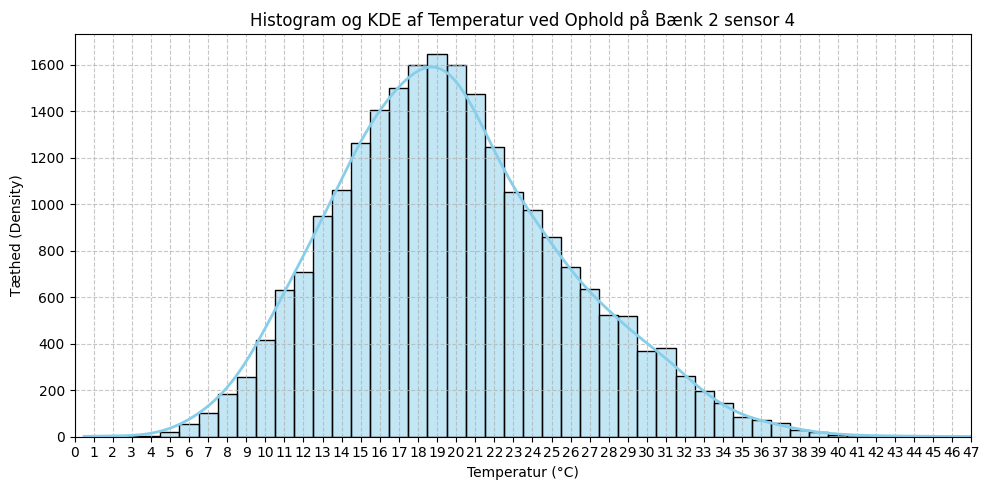

In [46]:
##Brug dette for at undersøge med dwell
# Fjern rækker med NaN i 'temp' eller 'dwell'
df_plot = df_s4.dropna(subset=["temp", "dwell"])

# Udvid x-aksen lidt for pænere plot
temp_extended = np.append(df_plot["temp"], df_plot["temp"].max() + 1)
#dwell_extended = np.append(df_plot["dwell"], 0)  # Tilføj 0 for at matche længden

## Plot histogram og KDE
plt.figure(figsize=(10, 5))
sns.histplot(
    temp_extended,
    kde=True,
    bins=np.arange(df_s4["temp"].min(), df_s4["temp"].max() + 2, 1),  # Ét bin per grad
    color="skyblue",
    alpha=0.5,
    #stat="density",
    stat="count",
    kde_kws={'bw_adjust': 1.5, 'cut': 0},     # Glat KDE
    line_kws={'color': 'red', 'linewidth': 2}
)

plt.title("Histogram og KDE af Temperatur ved Ophold på Bænk 2 sensor 4")
plt.xlabel("Temperatur (°C)")
plt.ylabel("Tæthed (Density)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(df_s4["temp"].min(), df_s4["temp"].max() + 1)


# X-ticks svarer til hele temperaturgrader
plt.xticks(np.arange(int(df_s4["temp"].min()), int(df_s4["temp"].max()) + 2, 1))

plt.tight_layout()
plt.show()

### Always last: Save data

In [27]:
benches_df = df
bench_df_s1 = df_s1
bench_df_s2 = df_s2
bench_df_s3 = df_s3
bench_df_s4 = df_s4

#bench_df_s1['date'] = pd.to_datetime(bench_df_s1['date']) #set date to datetime-format
#print(bench_df_s1['date'].dtype) #Check to see if done correctly

In [28]:
benches_df.to_csv("benches_df.csv", index=False)
bench_df_s1.to_csv("bench_df_s1.csv", index=False)
bench_df_s2.to_csv("bench_df_s2.csv", index=False)
bench_df_s3.to_csv("bench_df_s3.csv", index=False)
bench_df_s4.to_csv("bench_df_s4.csv", index=False)

In [29]:
bench_df_s1.head()

,dwell,temp,date,time,hour
0,3.150000,6.0,2020-06-05,09:19:06,9
1,3.150000,8.0,2020-06-05,10:11:11,10
2,7.216667,14.0,2020-06-05,12:46:34,12
3,3.116667,14.5,2020-06-05,13:04:14,13
4,2.966667,15.0,2020-06-05,13:24:58,13
